In [1]:
import numpy as np
from scipy.stats import multivariate_normal, norm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture

## Helper Functions

In [2]:
def initialize_parameters(X, K):
    '''
    X: input data
    K: number of clusters
    '''
    N, D = X.shape
    
    # use some of the data points as mean -> random
    # get K points from arange(N)
    indices = np.random.choice(N, K, replace=False)
    mu = X[indices]
    sigma = [np.eye(D) for _ in range(K)]
    pi = np.ones(K) / K
    
    return mu, sigma, pi

In [3]:
def e_step(X, mu, sigma, pi):
    N = X.shape[0]
    K = len(mu)
    gamma = np.zeros((N, K))
    
    for i in range(K):
        gamma[:,i] = pi[i] * multivariate_normal.pdf(X, mean=mu[i], cov=sigma[i])
        
    gamma /= gamma.sum(axis=1, keepdims=True)
    
    return gamma

In [4]:
def m_step(X, gamma):
    N, D = X.shape
    K = gamma.shape[1]
    N_i = gamma.sum(axis=0)
    
    mu = np.array([np.sum(gamma[:,i][:,np.newaxis] * X, axis=0) / N_i[i] for i in range(K)])
    
    sigma = []
    for i in range(K):
        diff = X - mu[i]
        cov_i = (gamma[:,i][:,np.newaxis] * diff).T @ diff/N_i[i]
        sigma.append(cov_i)
        
    pi = N_i/N
    
    return mu, sigma, pi

In [5]:
def compute_log_likelihood(X, mu, sigma, pi):
    N = X.shape[0]
    log_likelihood = 0
    
    for n in range(N):
        tmp = 0
        
        for i in range(len(mu)):
            tmp += pi[i] * multivariate_normal.pdf(X[n], mean=mu[i], cov=sigma[i])
            
        log_likelihood += np.log(tmp)
        
    return log_likelihood

In [6]:
def gmm_em(X, K, max_iters=100, tolerance=1e-4):
    mu, sigma, pi = initialize_parameters(X, K)
    log_likelihoods = []
    
    for i in range(max_iters):
        gamma = e_step(X, mu, sigma, pi)
        mu, sigma, pi = m_step(X, gamma)
        log_likelihood = compute_log_likelihood(X, mu, sigma, pi)
        log_likelihoods.append(log_likelihood)
        
        if i > 0 and abs(np.log(log_likelihoods[-1]) - np.log(log_likelihoods[-2])) < tolerance:
            break
            
    return mu, sigma, pi, gamma, log_likelihoods

## Generate 1D data

In [7]:
np.random.seed(42)
x1 = np.random.normal(0, 1, 100)
x2 = np.random.normal(5, 1, 50)
X = np.concatenate([x1, x2]).reshape(-1,1)
X

array([[ 4.96714153e-01],
       [-1.38264301e-01],
       [ 6.47688538e-01],
       [ 1.52302986e+00],
       [-2.34153375e-01],
       [-2.34136957e-01],
       [ 1.57921282e+00],
       [ 7.67434729e-01],
       [-4.69474386e-01],
       [ 5.42560044e-01],
       [-4.63417693e-01],
       [-4.65729754e-01],
       [ 2.41962272e-01],
       [-1.91328024e+00],
       [-1.72491783e+00],
       [-5.62287529e-01],
       [-1.01283112e+00],
       [ 3.14247333e-01],
       [-9.08024076e-01],
       [-1.41230370e+00],
       [ 1.46564877e+00],
       [-2.25776300e-01],
       [ 6.75282047e-02],
       [-1.42474819e+00],
       [-5.44382725e-01],
       [ 1.10922590e-01],
       [-1.15099358e+00],
       [ 3.75698018e-01],
       [-6.00638690e-01],
       [-2.91693750e-01],
       [-6.01706612e-01],
       [ 1.85227818e+00],
       [-1.34972247e-02],
       [-1.05771093e+00],
       [ 8.22544912e-01],
       [-1.22084365e+00],
       [ 2.08863595e-01],
       [-1.95967012e+00],
       [-1.3

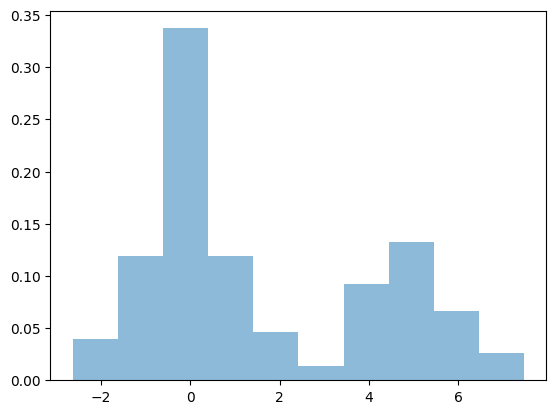

In [8]:
plt.hist(X, density=True, alpha=0.5, label='Actual Data')
plt.show()

In [9]:
mu, sigma, pi = initialize_parameters(X, 2)
mu, sigma, pi

(array([[6.54993441],
        [0.81252582]]),
 [array([[1.]]), array([[1.]])],
 array([0.5, 0.5]))

In [10]:
compute_log_likelihood(X, mu, sigma, pi)

-401.50733035675756

## Run GMM-EM on data

In [11]:
mu, sigma, pi, gamma, log_likelihoods = gmm_em(X, 2)
mu, sigma, pi

C:\Users\jerem\AppData\Local\Temp\ipykernel_15164\2171921951.py:11: RuntimeWarning: invalid value encountered in log
  if i > 0 and abs(np.log(log_likelihoods[-1]) - np.log(log_likelihoods[-2])) < tolerance:


(array([[ 4.95578756],
        [-0.10424341]]),
 [array([[1.02773625]]), array([[0.81822144]])],
 array([0.33371005, 0.66628995]))

## Plot

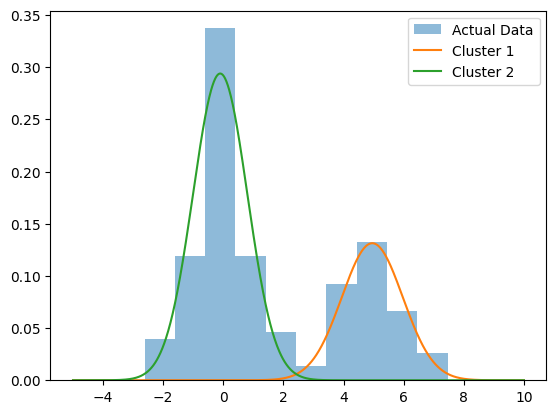

In [12]:
plt.hist(X, density=True, alpha=0.5, label='Actual Data')
x_plot = np.linspace(-5, 10, 1000)

for i in range(2):
    plt.plot(x_plot, pi[i]*norm.pdf(x_plot, loc=mu[i][0], scale=np.sqrt(sigma[i][0,0])), label=f'Cluster {i+1}')
    
plt.legend()
plt.show()

## Sklearn

In [13]:
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(X)

GaussianMixture(n_components=2)

In [14]:
estimated_means = gmm.means_
estimated_means

array([[ 4.95586518],
       [-0.10421868]])

In [15]:
estimated_vars = gmm.covariances_
estimated_vars

array([[[1.02751252]],

       [[0.818266  ]]])

In [16]:
estimated_weights = gmm.weights_
estimated_weights

array([0.33370168, 0.66629832])